In [69]:
# 1.Generating MNIST Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
import random
import numpy as np
import seaborn as sns

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

def apply_rotation_translation_noise(images, min_rotation=0, max_rotation=360, max_shift=0, noise_low=-0.1, noise_high=0.1):
    device = images.device
    batch_size = images.size(0)

    # Generate random angles between min_rotation and max_rotation
    angles = torch.rand(batch_size, device=device) * (max_rotation - min_rotation) + min_rotation
    translations = torch.rand(batch_size, 2, device=device) * 2 * max_shift - max_shift

    # Create base grid
    h, w = images.size(1), images.size(2)
    grid_h, grid_w = torch.meshgrid(torch.linspace(-1, 1, h, device=device),
                                   torch.linspace(-1, 1, w, device=device),
                                   indexing='ij')

    # Expand grid for batch processing
    grid_h = grid_h.expand(batch_size, h, w)
    grid_w = grid_w.expand(batch_size, h, w)

    transformed_images = []
    for idx in range(batch_size):
        # Convert angle to radians
        angle_rad = angles[idx] * torch.pi / 180.0

        # Rotation matrix components
        cos_theta = torch.cos(angle_rad)
        sin_theta = torch.sin(angle_rad)

        # Apply rotation
        rot_h = grid_h[idx] * cos_theta - grid_w[idx] * sin_theta
        rot_w = grid_h[idx] * sin_theta + grid_w[idx] * cos_theta

        # Apply translation
        trans_h = rot_h + translations[idx, 0] * 2 / h  # Normalize translation
        trans_w = rot_w + translations[idx, 1] * 2 / w

        # Stack coordinates
        grid = torch.stack([trans_w, trans_h], dim=2)

        # Apply transformation
        img = images[idx].unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
        transformed = F.grid_sample(img, grid.unsqueeze(0),
                                    mode='bilinear',
                                    padding_mode='zeros',
                                    align_corners=True)
        transformed_images.append(transformed.squeeze(0).squeeze(0))

    transformed_images = torch.stack(transformed_images)

    # Add uniform noise
    noise = torch.rand_like(transformed_images) * (noise_high - noise_low) + noise_low
    transformed_images = transformed_images + noise

    return torch.clamp(transformed_images, 0.0, 1.0)

train_dataset_data = train_dataset.data.float() / 255.0  
train_dataset_targets = train_dataset.targets
test_dataset_data = test_dataset.data.float() / 255.0 
test_dataset_targets = test_dataset.targets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset_data = train_dataset_data.to(device)
test_dataset_data = test_dataset_data.to(device)
train_dataset_targets = train_dataset_targets.to(device)
test_dataset_targets = test_dataset_targets.to(device)

test_images_transformed = apply_rotation_translation_noise(
    test_dataset_data,
    min_rotation=0,
    max_rotation=360,
    max_shift= 6, 
    noise_low=-0.5,
    noise_high=0.5
)

train_loader = DataLoader(TensorDataset(train_dataset_data, train_dataset_targets),
                         batch_size=16, shuffle=True)
test_loader = DataLoader(TensorDataset(test_images_transformed, test_dataset_targets),
                        batch_size=16, shuffle=False)

# Print shapes for verification
print("Training data shape:", train_dataset_data.shape)
print("Training targets shape:", train_dataset_targets.shape)
print("Test data shape:", test_dataset_data.shape)
print("Test targets shape:", test_dataset_targets.shape)
print("Transformed test images shape:", test_images_transformed.shape)
print("Training data range:", train_dataset_data.min().item(), "-", train_dataset_data.max().item())
print("Transformed test data range:", test_images_transformed.min().item(), "-", test_images_transformed.max().item())


Training data shape: torch.Size([60000, 28, 28])
Training targets shape: torch.Size([60000])
Test data shape: torch.Size([10000, 28, 28])
Test targets shape: torch.Size([10000])
Transformed test images shape: torch.Size([10000, 28, 28])
Training data range: 0.0 - 1.0
Transformed test data range: 0.0 - 1.0


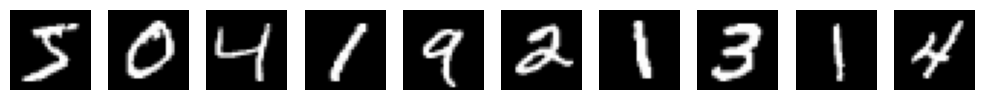

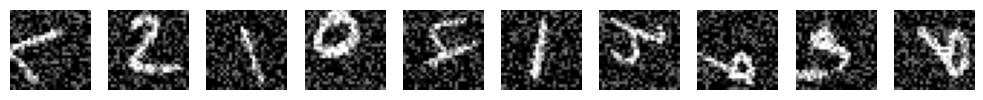

In [119]:
# 2. Data Visualization
def visualize_samples(dataset, title, num_samples=10, save_path=None):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        image, label = dataset[i]
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(image.cpu(), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')  # PNG 파일로 저장
    plt.show()

visualize_samples(
    TensorDataset(train_dataset_data, train_dataset_targets), 
    "Train", 
    save_path="train_samples.png"
)

visualize_samples(
    TensorDataset(test_images_transformed, test_dataset_targets), 
    "Domain Shift", 
    save_path="domain_shift_samples.png"
)

In [72]:
# 3. MLP Model (Including Batch Normalization) and Train
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(28*28,256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 1)
        self.rectification = False
        self.act = []
        self.feature = []
        self.threshold = 3

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.bn3(self.fc3(x))
        self.feature.append(x.clone()) 
        x = torch.relu(x)
        self.act.append(x.clone())
        if self.rectification:
            x = torch.clip(x,min = 0 , max = self.threshold)
        x = self.fc4(x)
        return x

    def clear_act(self):
        self.act = None
        self.act = []
    
    def clear_feat(self):
        self.feature = None
        self.feature = []
    
    def change_threshold(self, threshold):
        self.threshold = threshold

model = RegressionModel().to(device)  # Move model to device
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 50
model.train()
noise_level = 0.01
for epoch in range(epochs):
    model.train()
    model.rectification = False
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)  
        labels = labels.to(device)  
        images = images.view(-1, 28 * 28)
        labels = labels.float() + torch.randn_like(labels.float()) * noise_level
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")


Epoch [1/50], Loss: 4.1360
Epoch [2/50], Loss: 1.2318
Epoch [3/50], Loss: 1.0530
Epoch [4/50], Loss: 0.9191
Epoch [5/50], Loss: 0.8347
Epoch [6/50], Loss: 0.7381
Epoch [7/50], Loss: 0.7048
Epoch [8/50], Loss: 0.6453
Epoch [9/50], Loss: 0.6001
Epoch [10/50], Loss: 0.5444
Epoch [11/50], Loss: 0.5257
Epoch [12/50], Loss: 0.4923
Epoch [13/50], Loss: 0.4528
Epoch [14/50], Loss: 0.4561
Epoch [15/50], Loss: 0.4257
Epoch [16/50], Loss: 0.4005
Epoch [17/50], Loss: 0.3705
Epoch [18/50], Loss: 0.3670
Epoch [19/50], Loss: 0.3493
Epoch [20/50], Loss: 0.3331
Epoch [21/50], Loss: 0.3215
Epoch [22/50], Loss: 0.3108
Epoch [23/50], Loss: 0.2971
Epoch [24/50], Loss: 0.2864
Epoch [25/50], Loss: 0.2787
Epoch [26/50], Loss: 0.2682
Epoch [27/50], Loss: 0.2539
Epoch [28/50], Loss: 0.2524
Epoch [29/50], Loss: 0.2416
Epoch [30/50], Loss: 0.2377
Epoch [31/50], Loss: 0.2323
Epoch [32/50], Loss: 0.2128
Epoch [33/50], Loss: 0.2168
Epoch [34/50], Loss: 0.2163
Epoch [35/50], Loss: 0.2044
Epoch [36/50], Loss: 0.2047
E

In [115]:
# 4. Evaluation on ID(In-Distribution) After Model Training
model.clear_act()
model.eval()
model.rectification = False

total_mse = 0.0
total_mae = 0.0
total_samples = 0

all_predictions = []
all_true_labels = []

with torch.no_grad():
    for train_samples, train_labels in train_loader:

        train_samples = train_samples.to(device)
        train_labels = train_labels.to(device).float()

        train_samples_flat = train_samples.view(-1, 28 * 28)

        train_outputs = model(train_samples_flat).squeeze()

        all_predictions.append(train_outputs.cpu())
        all_true_labels.append(train_labels.cpu())

        mse = F.mse_loss(train_outputs, train_labels, reduction='sum')
        mae = F.l1_loss(train_outputs, train_labels, reduction='sum')

        total_mse += mse.item()
        total_mae += mae.item()
        total_samples += train_labels.size(0)

all_predictions = torch.cat(all_predictions)
all_true_labels = torch.cat(all_true_labels)

avg_mse = total_mse / total_samples
avg_mae = total_mae / total_samples

errors = all_predictions - all_true_labels

bias = torch.mean(errors).item()
variance = torch.var(errors).item()

rmse = torch.sqrt(torch.tensor(avg_mse)).item()

print(f"Test Set Results:")
print(f"Average MSE: {avg_mse:.4f}")
print(f"Average MAE: {avg_mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Bias: {bias:.4f}")
print(f"Variance: {variance:.4f}")

# MSE = Bias^2 + Variance
mse_from_bias_variance = bias**2 + variance
print(f"MSE from Bias^2 + Variance: {mse_from_bias_variance:.4f}")

Test Set Results:
Average MSE: 0.0860
Average MAE: 0.2355
RMSE: 0.2932
Bias: -0.2046
Variance: 0.0441
MSE from Bias^2 + Variance: 0.0860


/home/jiwoo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jiwoo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


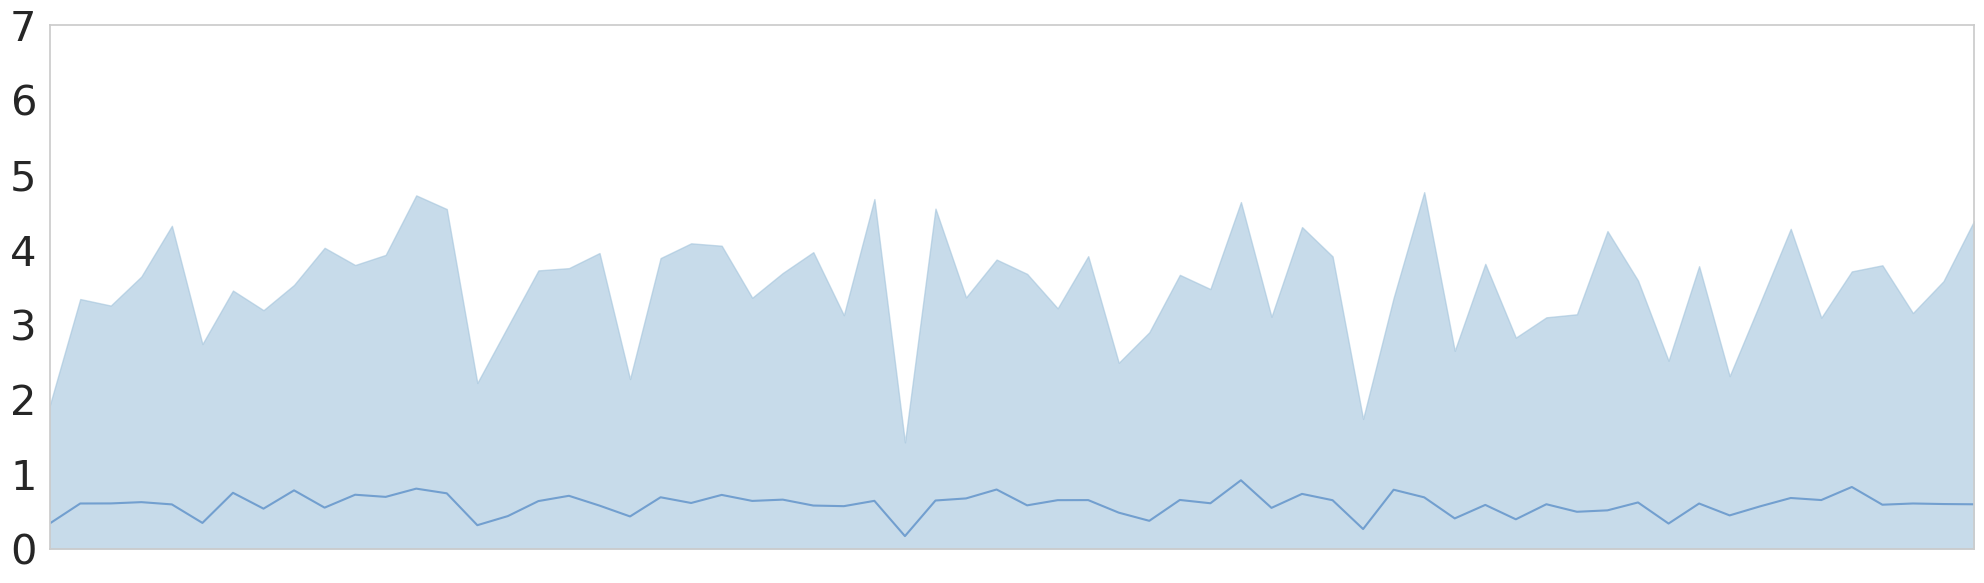

In [116]:
# 5. ID Activation Figure 
activations = model.act  
sns.set(style="whitegrid")

all_data = torch.cat([tensor.cpu() for tensor in activations]) 
all_data = all_data.numpy()  

num_units = all_data.shape[1]

overall_means = [np.mean(all_data[:, unit]) for unit in range(num_units)]
overall_max = [np.max(all_data[:, unit]) for unit in range(num_units)]
overall_min = [np.min(all_data[:, unit]) for unit in range(num_units)]

x = np.arange(1, num_units + 1)  

plt.figure(figsize=(20, 6))
sns.lineplot(x=x, y=overall_means, color="#729FCF", linewidth=1.5) 
plt.fill_between(x, overall_min, overall_max, color="#A3C4DC", alpha=0.6)  
plt.grid(False)
plt.xticks([], fontsize=12)  # x축 레이블 비활성화
plt.yticks(ticks=np.arange(0, 8, 1), fontsize=30)  # y축 0에서 7로 고정
plt.xlim(1,64)
plt.ylim(0, 7)  # y축 범위 0~7로 고정
plt.tight_layout()

plt.savefig("id_act.png",dpi=300, bbox_inches='tight')
plt.show()

In [117]:
# 6. Evaluation on OOD(Out-of-Distribution), with out rectified activation
model.clear_act()
model.eval()
model.rectification = False

total_mse = 0.0
total_mae = 0.0
total_samples = 0

all_predictions = []
all_true_labels = []

with torch.no_grad():
    for test_samples, test_labels in test_loader:
        test_samples = test_samples.to(device)
        test_labels = test_labels.to(device).float()

        test_samples_flat = test_samples.view(-1, 28 * 28)

        test_outputs = model(test_samples_flat).squeeze()

        all_predictions.append(test_outputs.cpu())
        all_true_labels.append(test_labels.cpu())

        mse = F.mse_loss(test_outputs, test_labels, reduction='sum')
        mae = F.l1_loss(test_outputs, test_labels, reduction='sum')

        total_mse += mse.item()
        total_mae += mae.item()
        total_samples += test_labels.size(0)

all_predictions = torch.cat(all_predictions)
all_true_labels = torch.cat(all_true_labels)

avg_mse = total_mse / total_samples
avg_mae = total_mae / total_samples

errors = all_predictions - all_true_labels

bias = torch.mean(errors).item()
variance = torch.var(errors).item()

rmse = torch.sqrt(torch.tensor(avg_mse)).item()

print(f"Test Set Results:")
print(f"Average MSE: {avg_mse:.4f}")
print(f"Average MAE: {avg_mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Bias: {bias:.4f}")
print(f"Variance: {variance:.4f}")

mse_from_bias_variance = bias**2 + variance
print(f"MSE from Bias^2 + Variance: {mse_from_bias_variance:.4f}")

Test Set Results:
Average MSE: 11.4142
Average MAE: 2.7919
RMSE: 3.3785
Bias: 1.3474
Variance: 9.5997
MSE from Bias^2 + Variance: 11.4152


/home/jiwoo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jiwoo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


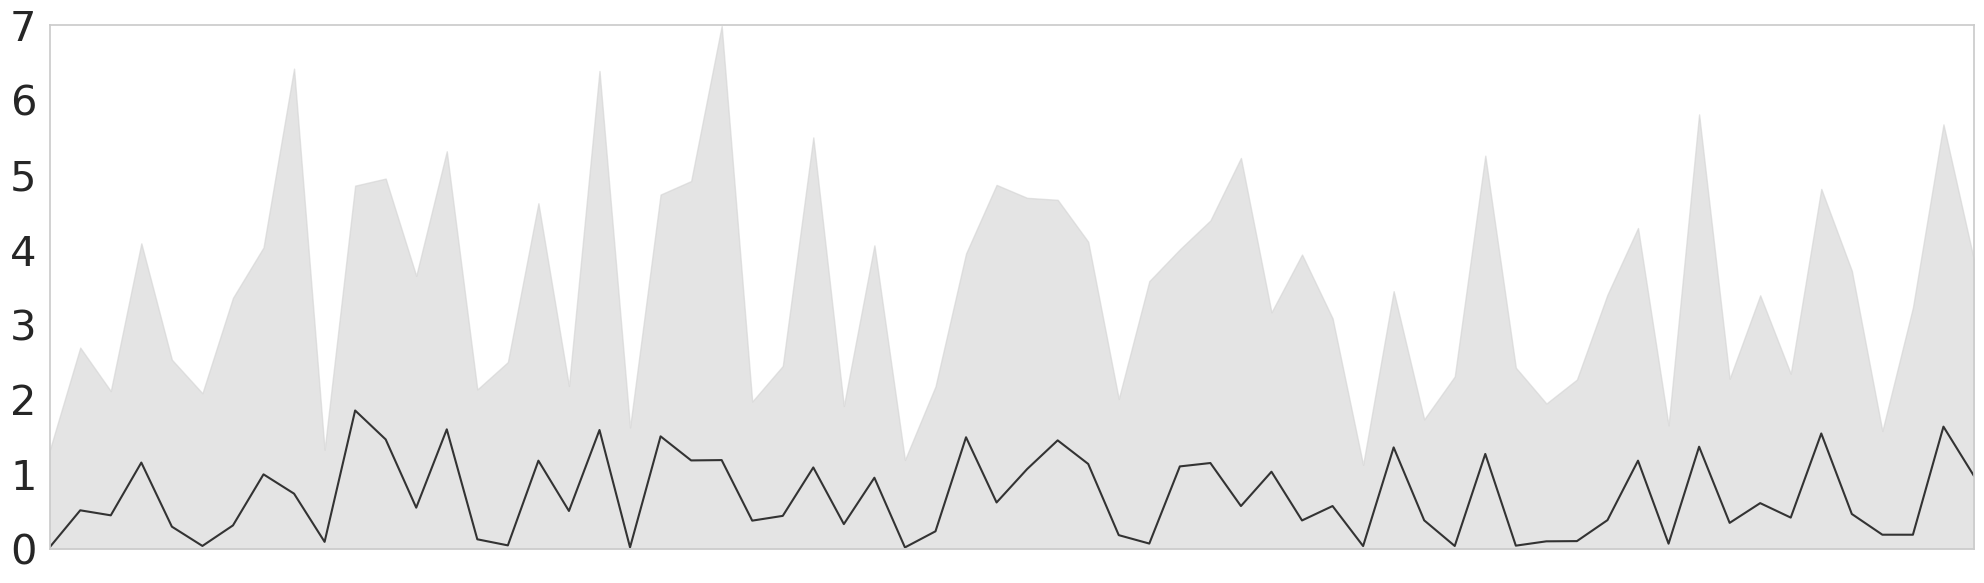

In [118]:
# 7. OOD Activation Figure
activations = model.act 

sns.set(style="whitegrid")

all_data = torch.cat([tensor.cpu() for tensor in activations])  
all_data = all_data.numpy() 

num_units = all_data.shape[1]

overall_means = [np.mean(all_data[:, unit]) for unit in range(num_units)]
overall_max = [np.max(all_data[:, unit]) for unit in range(num_units)]
overall_min = [np.min(all_data[:, unit]) for unit in range(num_units)]

x = np.arange(1, num_units + 1)  


plt.figure(figsize=(20, 6))
sns.lineplot(x=x, y=overall_means, color="#333333", linewidth=1.5)  
plt.fill_between(x, overall_min, overall_max, color="lightgray", alpha=0.6)  
plt.grid(False)
plt.xticks([], fontsize=12)  
plt.yticks(ticks=np.arange(0, 8, 1), fontsize=30) 
plt.xlim(1,64)
plt.ylim(0, 7)  
plt.tight_layout()
plt.savefig("ood_act.png",dpi=300, bbox_inches='tight')
plt.show()


In [121]:
# 8. Evaluation on OOD, with rectified activation
model.change_threshold(3)
model.eval()
model.rectification = True

total_mse = 0.0
total_mae = 0.0
total_samples = 0

all_predictions = []
all_true_labels = []

with torch.no_grad():
    for test_samples, test_labels in test_loader:

        test_samples = test_samples.to(device)
        test_labels = test_labels.to(device).float()

        test_samples_flat = test_samples.view(-1, 28 * 28)
        test_outputs = model(test_samples_flat).squeeze()

        all_predictions.append(test_outputs.cpu())
        all_true_labels.append(test_labels.cpu())
        mse = F.mse_loss(test_outputs, test_labels, reduction='sum')
        mae = F.l1_loss(test_outputs, test_labels, reduction='sum')

        total_mse += mse.item()
        total_mae += mae.item()
        total_samples += test_labels.size(0)


all_predictions = torch.cat(all_predictions)
all_true_labels = torch.cat(all_true_labels)

avg_mse = total_mse / total_samples
avg_mae = total_mae / total_samples


errors = all_predictions - all_true_labels
bias = torch.mean(errors).item()
variance = torch.var(errors).item()

rmse = torch.sqrt(torch.tensor(avg_mse)).item()


print(f"Test Set Results:")
print(f"Average MSE: {avg_mse:.4f}")
print(f"Average MAE: {avg_mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Bias: {bias:.4f}")
print(f"Variance: {variance:.4f}")
mse_from_bias_variance = bias**2 + variance
print(f"MSE from Bias^2 + Variance: {mse_from_bias_variance:.4f}")


Test Set Results:
Average MSE: 11.3182
Average MAE: 2.7834
RMSE: 3.3643
Bias: 1.3259
Variance: 9.5611
MSE from Bias^2 + Variance: 11.3192
